In [1]:
import pandas
import konlpy
import gensim

print(pandas.__version__)
print(konlpy.__version__)
print(gensim.__version__)

1.3.3
0.5.2
4.1.2


# 1. 데이터 준비와 확인

In [2]:
import pandas as pd

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/0612_sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/0612_sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


# 2. 데이터로더 구성

In [14]:
from konlpy.tag import Mecab
import numpy as np
from collections import Counter

tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    # [[YOUR CODE]]
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(num_words-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

In [15]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [16]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] 
                                         if word in word_to_index 
                                         else word_to_index['<UNK>'] 
                                         for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word 
                                         else '<UNK>' 
                                         for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

# 3. 모델 구성을 위한 데이터 분석 및 가공

In [17]:
total_data_text = list(X_train) + list(X_test)

# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)

# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print(f'전체 문장의 {np.sum(num_tokens < max_tokens) / len(num_tokens)}%가 maxlen 설정값 이내에 포함됩니다. ')

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


In [19]:
# 위의 maxlen 을 기준으로 패딩. 앞쪽에 패딩을 붙이자.

import numpy as np
import tensorflow as tf
import os

X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre',
                                                        maxlen=maxlen)

X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre',
                                                       maxlen=maxlen)

print(X_train.shape)

(146182, 41)


# 4. 모델 구성 및 validation set 구성

In [21]:
# 총 146182 건의 데이터 중 40000 건을 검증용으로 사용하자.
# validation set 40000건 분리
X_val = X_train[:40000]   
y_val = y_train[:40000]

# validation set을 제외한 나머지 106182건
partial_X_train = X_train[40000:]  
partial_y_train = y_train[40000:]

print(partial_X_train.shape)
print(partial_y_train.shape)

(106182, 41)
(106182,)


In [22]:
# 단어장 크기와 임베딩벡터의 차원을 명시
vocab_size = 10000
word_vector_dim = 128

In [39]:
# 모델 1 : 단방향 LSTM 2층으로 쌓기

lstm_model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_length=maxlen),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

lstm_model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 41, 128)           1280000   
_________________________________________________________________
lstm_10 (LSTM)               (None, 41, 64)            49408     
_________________________________________________________________
lstm_11 (LSTM)               (None, 64)                33024     
_________________________________________________________________
dense_12 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 65        
Total params: 1,366,657
Trainable params: 1,366,657
Non-trainable params: 0
____________________________________________

In [40]:
# 모델 2 : 쌍방향 LSTM 2층으로 쌓기

bi_lstm_model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_length=maxlen),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

bi_lstm_model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 41, 128)           1280000   
_________________________________________________________________
bidirectional_4 (Bidirection (None, 41, 128)           98816     
_________________________________________________________________
bidirectional_5 (Bidirection (None, 128)               98816     
_________________________________________________________________
dense_14 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_6 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 65        
Total params: 1,485,953
Trainable params: 1,485,953
Non-trainable params: 0
____________________________________________

In [41]:
# 모델 3 : 1d-CNN

cnn_model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_length=maxlen),
    tf.keras.layers.Conv1D(16, 7, activation='relu'),
    tf.keras.layers.MaxPooling1D(5),
    tf.keras.layers.Conv1D(16, 7, activation='relu'),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

cnn_model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 41, 128)           1280000   
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 35, 16)            14352     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 7, 16)             0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1, 16)             1808      
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 16)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_17 (Dense)             (None, 1)                

# 5. 모델 훈련

In [32]:
lstm_model.compile(optimizer='adam',
                   loss='binary_crossentropy',
                   metrics=['accuracy'])
              
epochs=10  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

lstm_history = lstm_model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/10
208/208 [==============================] - 8s 15ms/step - loss: 0.4382 - accuracy: 0.7942 - val_loss: 0.3541 - val_accuracy: 0.8449
Epoch 2/10
208/208 [==============================] - 2s 11ms/step - loss: 0.3264 - accuracy: 0.8630 - val_loss: 0.3373 - val_accuracy: 0.8528
Epoch 3/10
208/208 [==============================] - 2s 11ms/step - loss: 0.2890 - accuracy: 0.8800 - val_loss: 0.3340 - val_accuracy: 0.8558
Epoch 4/10
208/208 [==============================] - 2s 11ms/step - loss: 0.2569 - accuracy: 0.8934 - val_loss: 0.3528 - val_accuracy: 0.8542
Epoch 5/10
208/208 [==============================] - 2s 11ms/step - loss: 0.2260 - accuracy: 0.9083 - val_loss: 0.3655 - val_accuracy: 0.8530
Epoch 6/10
208/208 [==============================] - 2s 11ms/step - loss: 0.1993 - accuracy: 0.9200 - val_loss: 0.4047 - val_accuracy: 0.8476
Epoch 7/10
208/208 [==============================] - 2s 11ms/step - loss: 0.1776 - accuracy: 0.9281 - val_loss: 0.4386 - val_accuracy: 0.8485

In [33]:
bi_lstm_model.compile(optimizer='adam',
                   loss='binary_crossentropy',
                   metrics=['accuracy'])
              
epochs=10  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

bi_lstm_history = bi_lstm_model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/10
208/208 [==============================] - 11s 29ms/step - loss: 0.4274 - accuracy: 0.7997 - val_loss: 0.3570 - val_accuracy: 0.8457
Epoch 2/10
208/208 [==============================] - 5s 23ms/step - loss: 0.3254 - accuracy: 0.8639 - val_loss: 0.3351 - val_accuracy: 0.8543
Epoch 3/10
208/208 [==============================] - 5s 23ms/step - loss: 0.2867 - accuracy: 0.8808 - val_loss: 0.3563 - val_accuracy: 0.8507
Epoch 4/10
208/208 [==============================] - 5s 23ms/step - loss: 0.2531 - accuracy: 0.8950 - val_loss: 0.3552 - val_accuracy: 0.8536
Epoch 5/10
208/208 [==============================] - 5s 23ms/step - loss: 0.2239 - accuracy: 0.9081 - val_loss: 0.3696 - val_accuracy: 0.8524
Epoch 6/10
208/208 [==============================] - 5s 23ms/step - loss: 0.1974 - accuracy: 0.9189 - val_loss: 0.4248 - val_accuracy: 0.8514
Epoch 7/10
208/208 [==============================] - 5s 23ms/step - loss: 0.1764 - accuracy: 0.9274 - val_loss: 0.4584 - val_accuracy: 0.844

In [34]:
cnn_model.compile(optimizer='adam',
                   loss='binary_crossentropy',
                   metrics=['accuracy'])
              
epochs=10  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

cnn_history = cnn_model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/10
208/208 [==============================] - 4s 8ms/step - loss: 0.4555 - accuracy: 0.7839 - val_loss: 0.3468 - val_accuracy: 0.8489
Epoch 2/10
208/208 [==============================] - 1s 6ms/step - loss: 0.3038 - accuracy: 0.8728 - val_loss: 0.3300 - val_accuracy: 0.8565
Epoch 3/10
208/208 [==============================] - 1s 6ms/step - loss: 0.2451 - accuracy: 0.9024 - val_loss: 0.3373 - val_accuracy: 0.8577
Epoch 4/10
208/208 [==============================] - 1s 6ms/step - loss: 0.1804 - accuracy: 0.9331 - val_loss: 0.3788 - val_accuracy: 0.8503
Epoch 5/10
208/208 [==============================] - 1s 6ms/step - loss: 0.1192 - accuracy: 0.9597 - val_loss: 0.4298 - val_accuracy: 0.8448
Epoch 6/10
208/208 [==============================] - 1s 6ms/step - loss: 0.0769 - accuracy: 0.9758 - val_loss: 0.5063 - val_accuracy: 0.8416
Epoch 7/10
208/208 [==============================] - 1s 6ms/step - loss: 0.0524 - accuracy: 0.9843 - val_loss: 0.5635 - val_accuracy: 0.8422
Epoch 

In [43]:
# 세 모델의 최적의 에포크는 각각 3, 2, 2 임을 안다.
# 이 값들로 다시 fitting

lstm_model.compile(optimizer='adam',
                   loss='binary_crossentropy',
                   metrics=['accuracy'])

bi_lstm_model.compile(optimizer='adam',
                   loss='binary_crossentropy',
                   metrics=['accuracy'])

cnn_model.compile(optimizer='adam',
                   loss='binary_crossentropy',
                   metrics=['accuracy'])




lstm_model.fit(partial_X_train,
                    partial_y_train,
                    epochs=3,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

bi_lstm_model.fit(partial_X_train,
                    partial_y_train,
                    epochs=2,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

cnn_model.fit(partial_X_train,
                    partial_y_train,
                    epochs=2,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

lstm_results = lstm_model.evaluate(X_test,  y_test, verbose=2)
bi_lstm_results = bi_lstm_model.evaluate(X_test,  y_test, verbose=2)
cnn_results = cnn_model.evaluate(X_test,  y_test, verbose=2)
print(lstm_results)
print(bi_lstm_results)
print(cnn_results)

Epoch 1/3
208/208 [==============================] - 6s 15ms/step - loss: 0.4340 - accuracy: 0.7989 - val_loss: 0.3510 - val_accuracy: 0.8456
Epoch 2/3
208/208 [==============================] - 2s 12ms/step - loss: 0.3257 - accuracy: 0.8627 - val_loss: 0.3373 - val_accuracy: 0.8533
Epoch 3/3
208/208 [==============================] - 2s 12ms/step - loss: 0.2891 - accuracy: 0.8790 - val_loss: 0.3401 - val_accuracy: 0.8546
Epoch 1/2
208/208 [==============================] - 11s 29ms/step - loss: 0.4269 - accuracy: 0.8002 - val_loss: 0.3490 - val_accuracy: 0.8483
Epoch 2/2
208/208 [==============================] - 5s 23ms/step - loss: 0.3246 - accuracy: 0.8630 - val_loss: 0.3415 - val_accuracy: 0.8532
Epoch 1/2
208/208 [==============================] - 2s 7ms/step - loss: 0.4640 - accuracy: 0.7821 - val_loss: 0.3487 - val_accuracy: 0.8473
Epoch 2/2
208/208 [==============================] - 1s 6ms/step - loss: 0.3112 - accuracy: 0.8684 - val_loss: 0.3341 - val_accuracy: 0.8544
1537/15

# 6. Loss, Accuracy 그래프 시각화

In [44]:
# 가장 높은 accuracy 를 준 1D-CNN 모델의 그래프를 시각화해보자.
history_dict = cnn_history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


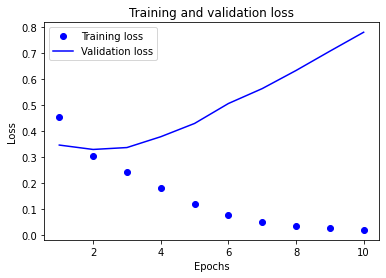

In [45]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')  # "bo"는 "파란색 점"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')  # b는 "파란 실선"입니다
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

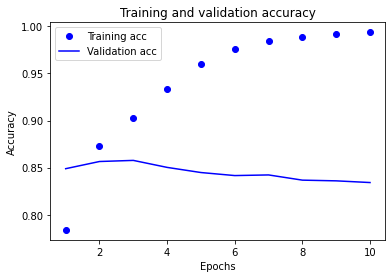

In [46]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# 7. 학습된 embedding layer 분석

In [48]:
# 첫 레이어 embedding 에, 우리의 모델이 잘 훈련되었다면, 그럴듯한 word-embedding 이 이루어졌을 것이다.
# 이를 확인해보자.

# 먼저 임베딩된 벡터들을 저장할 디렉토리를 만들고, 
# 워드벡터를 다루는데 유용한 gensim 패키지버전 확인... 먼저 터미널에서 다음을 입력:
# $ mkdir -p ~/aiffel/sentiment_classification/data
# $ pip list | grep gensim

embedding_layer = cnn_model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 128)


In [50]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/0612_sentiment_classification/data/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = cnn_model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [53]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['사랑']
vector

array([-0.08401033, -0.0889575 , -0.00855551, -0.05298588,  0.04927721,
        0.07869884, -0.06560596,  0.01237868,  0.02954806,  0.02870614,
       -0.07214991, -0.00983764, -0.04209622,  0.01026887,  0.05460407,
        0.06487674,  0.04089818,  0.01329043, -0.05047166,  0.05364168,
        0.06288224, -0.01204511, -0.04944069,  0.0185559 ,  0.06141255,
       -0.09189028,  0.07322226, -0.03996252,  0.07270923,  0.02646896,
        0.03523599,  0.03778783, -0.0637747 ,  0.07805342, -0.06922435,
       -0.00540882, -0.03396018, -0.01766626, -0.01310455,  0.0397407 ,
       -0.07759216,  0.01162062, -0.04845211,  0.04555965, -0.07468257,
       -0.03525211,  0.01424592,  0.00502706,  0.05274574, -0.02539675,
        0.00561628, -0.04417329, -0.05209601, -0.02081716, -0.01504637,
        0.01039113,  0.05942878,  0.00093929,  0.00046026,  0.03606026,
       -0.07417139, -0.06324904,  0.0555009 , -0.05847939, -0.03907322,
       -0.00635329, -0.04003576,  0.08075479, -0.06431447, -0.08

In [54]:
# 워드 벡터가 의미 벡터 공간상에 유의미하게 학습되었는지 확인하는 방법 중에, 
# 단어를 하나 주고 그와 가장 유사한 단어와 그 유사도를 확인하는 방법이 있습니다. 
# gensim을 사용하면 아래와 같이 해볼 수 있습니다.

word_vectors.similar_by_word("사랑")

[('먹먹', 0.7569153904914856),
 ('진진', 0.7524681687355042),
 ('담백', 0.7428818345069885),
 ('정점', 0.7350031733512878),
 ('해냈', 0.7236530184745789),
 ('진한', 0.7234598398208618),
 ('good', 0.7224597930908203),
 ('레전드', 0.7203169465065002),
 ('묵직', 0.7172957062721252),
 ('입감', 0.7167129516601562)]

# 8. 한국어 Word2Vec 임베딩을 활용하여 성능 개선

In [62]:
# Word2Vec 모델 파일 경로
word2vec_file_path = os.getenv('HOME')+'/data/word2vec_ko.model'
# Word2Vec 모델 로드
word_vectors = Word2VecKeyedVectors.load(word2vec_file_path)

vector = word_vectors.wv['사랑']
vector

array([ 3.2565942 , -0.85421413, -3.6964011 ,  1.0956469 ,  0.599815  ,
       -1.9681435 ,  0.32379073, -1.0716053 , -1.1776937 ,  2.0442047 ,
        2.2501915 , -2.7868037 , -2.702359  , -0.9775915 , -0.12478333,
        0.28235647,  0.77683175, -1.5393747 ,  2.0879042 , -5.444462  ,
       -4.931412  ,  0.8532094 ,  0.11118065, -2.743522  ,  0.7902363 ,
        0.10469969, -0.56074625,  1.6684421 ,  1.0278419 , -3.8816829 ,
       -3.606887  , -3.120771  , -1.2527398 , -0.77196646, -1.0102901 ,
        3.331668  ,  0.30032924,  1.2074511 , -1.2813627 ,  2.6281219 ,
       -1.4624823 , -1.1354805 ,  0.7605239 ,  2.83577   , -1.199358  ,
        3.1347232 ,  4.062026  , -0.23413125,  3.205856  , -0.9567054 ,
        0.77167803, -1.4300145 ,  2.9014013 , -3.940087  , -3.234169  ,
       -5.5460634 ,  0.6185009 , -0.75793767,  2.1043491 ,  2.350599  ,
        2.9313247 , -2.235593  ,  3.2084036 , -5.594638  ,  1.6516634 ,
       -0.32628602, -1.8824683 , -1.5573231 , -1.8452163 , -1.40

In [64]:
word_vectors.wv.similar_by_word("사랑") # 위의 영화 리뷰에서나 자주 등장할만한 어휘와는 달리 더 연관성 있어보인다.

[('이별', 0.7626414895057678),
 ('행복', 0.7550068497657776),
 ('슬픔', 0.7381505966186523),
 ('유혹', 0.7238055467605591),
 ('그리움', 0.7167419195175171),
 ('추억', 0.7143999338150024),
 ('꿈', 0.7089294195175171),
 ('애정', 0.7066588997840881),
 ('포옹', 0.7034594416618347),
 ('마음', 0.6972615718841553)]

In [65]:
len(vector) # 영어 모델의 300 차원에 비하면 작다.

100

In [69]:
# 이제 우리의 모델의 embedding layer 를 Word2Vec 의 것으로 교체하여 다시 학습시켜보자.
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 100  # 워드 벡터의 차원수
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word_vectors.wv:
        embedding_matrix[i] = word_vectors.wv[index_to_word[i]]

In [71]:
# 이제 모델을 구성하고 fine tuning.

from tensorflow.keras.initializers import Constant


model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(5))
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid')) 

model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 41, 100)           1000000   
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 35, 16)            11216     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 7, 16)             0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 1, 16)             1808      
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 16)                0         
_________________________________________________________________
dense_18 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_19 (Dense)             (None, 1)               

In [73]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/20
208/208 [==============================] - 2s 7ms/step - loss: 0.2344 - accuracy: 0.9082 - val_loss: 0.3904 - val_accuracy: 0.8428
Epoch 2/20
208/208 [==============================] - 1s 6ms/step - loss: 0.2218 - accuracy: 0.9133 - val_loss: 0.4003 - val_accuracy: 0.8410
Epoch 3/20
208/208 [==============================] - 1s 6ms/step - loss: 0.2110 - accuracy: 0.9187 - val_loss: 0.4101 - val_accuracy: 0.8407
Epoch 4/20
208/208 [==============================] - 1s 6ms/step - loss: 0.2024 - accuracy: 0.9230 - val_loss: 0.4254 - val_accuracy: 0.8396
Epoch 5/20
208/208 [==============================] - 1s 6ms/step - loss: 0.1924 - accuracy: 0.9276 - val_loss: 0.4361 - val_accuracy: 0.8377
Epoch 6/20
208/208 [==============================] - 1s 6ms/step - loss: 0.1832 - accuracy: 0.9326 - val_loss: 0.4614 - val_accuracy: 0.8332
Epoch 7/20
208/208 [==============================] - 1s 6ms/step - loss: 0.1739 - accuracy: 0.9367 - val_loss: 0.4577 - val_accuracy: 0.8356
Epoch 

In [75]:
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.7654 - accuracy: 0.8246
[0.765363872051239, 0.8246434926986694]


오히려 성능이 떨어졌다... 데이터를 분석해보신 분의 말씀에 따르면 word 의 30% 가량이 UNK 으로 나온다고 한다. 인터넷 은어가 많이 쓰여서 오히려 처음부터 학습시킨 것보다 성능이 떨어지는 것으로 보인다.